In [2]:
import pandas as pd
import json

with open('../../score_distributions/BAYC_totalScoreDistribution.json') as f:
    ds = json.load(f)

columns = ds['columns']
distributions = ds['distributions']
indexes = []

for distribution in distributions:
    indexes.append(distribution['tokenId'])

data = pd.DataFrame(columns=[*columns], index=indexes)

for index, token in enumerate(data.index):
    data.loc[token] = distributions[index]['totalScoreDistribution']

data.head()

,Hat,Mouth,Clothes,Eyes,Earring,Background,Fur,trait_count
8135,153.846154,357.142857,78.125,45.454545,12.150668,8.045052,8.136697,5.310674
2794,84.033613,384.615385,37.878788,92.592593,7.898894,3.937008,4.432624,1.42369
7678,7.745933,28.571429,129.87013,24.630542,35.211268,384.615385,1.878993,1.42369
8976,41.322314,25.188917,384.615385,12.150668,7.794232,70.921986,54.945055,5.310674
208,20.876827,26.525199,8.045052,384.615385,12.150668,19.569472,97.087379,5.310674


In [3]:
data.shape

(9999, 8)

In [4]:
data.columns

Index(['Hat', 'Mouth', 'Clothes', 'Eyes', 'Earring', 'Background', 'Fur',
       'trait_count'],
      dtype='object')

In [5]:
data.describe().transpose()

,count,unique,top,freq
Hat,9999.0,146.0,4.401408,397.0
Mouth,9999.0,146.0,4.401408,384.0
Clothes,9999.0,146.0,4.401408,389.0
Eyes,9999.0,146.0,4.401408,390.0
Earring,9999.0,147.0,4.401408,375.0
Background,9999.0,148.0,3.937008,2540.0
Fur,9999.0,140.0,1.878993,5322.0
trait_count,9999.0,4.0,1.423690,7023.0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9999 entries, 8135 to 9810
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Hat          9999 non-null   object
 1   Mouth        9999 non-null   object
 2   Clothes      9999 non-null   object
 3   Eyes         9999 non-null   object
 4   Earring      9999 non-null   object
 5   Background   9999 non-null   object
 6   Fur          9999 non-null   object
 7   trait_count  9999 non-null   object
dtypes: object(8)
memory usage: 961.1+ KB


In [7]:
from sklearn.decomposition import PCA
import seaborn as sns
import numpy as np

pca = PCA(n_components=5)
pcs = pca.fit_transform(data)
pca.explained_variance_ratio_.cumsum()
# print('Cumulative variance explained by 2 principal components: {:.2%}'.format(
#         np.sum(pca.explained_variance_ratio_)))

array([0.17478563, 0.34623439, 0.5133824 , 0.67894487, 0.8293066 ])

<AxesSubplot: >

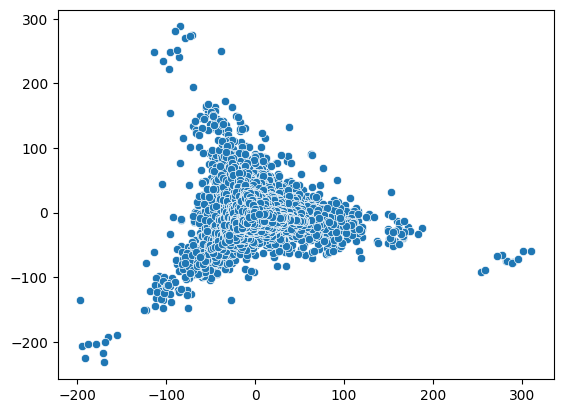

In [8]:
pc1_values = pcs[:,0]
pc2_values = pcs[:,1]
sns.scatterplot(x=pc1_values, y=pc2_values)

Text(0.5, 1.0, 'Clustered NFT Data Reduced with PCA')

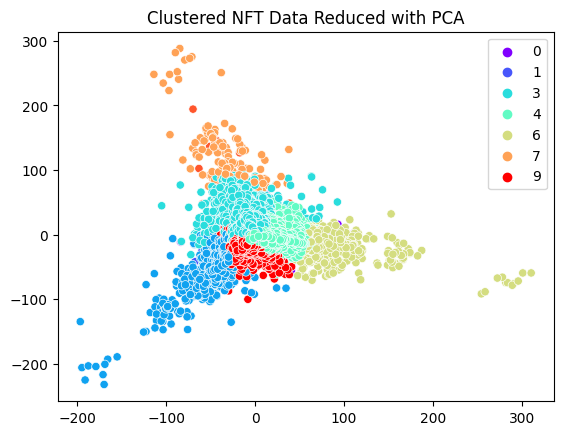

In [9]:
from sklearn.cluster import AgglomerativeClustering

clustering_model_pca = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='ward')
clustering_model_pca.fit(pcs)

data_labels_pca = clustering_model_pca.labels_

sns.scatterplot(x=pc1_values, 
                y=pc2_values,
                hue=data_labels_pca,
                palette="rainbow").set_title('Clustered NFT Data Reduced with PCA')

Choosing appropriate number of clusters

We try to find the Knee bar for optimum number of clusters

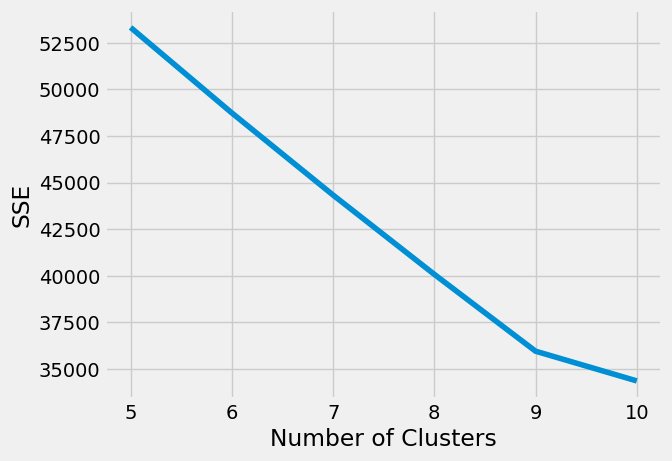

In [10]:
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

kmeans_kwargs = {
    "init": "random",
    "n_init": 50,
    "max_iter": 500,
}

scaler = StandardScaler()
scaled_features = scaler.fit_transform(data)

sse = []
for k in range(5, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

plt.style.use("fivethirtyeight")
plt.plot(range(5, 11), sse)
plt.xticks(range(5, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE") 
plt.show()

In [11]:
kl = KneeLocator(range(5, 11), sse, curve='convex', direction="decreasing")
kl.elbow

/Users/zakirefai/Library/Python/3.8/lib/python/site-packages/kneed/knee_locator.py:311: UserWarning: No knee/elbow found
  warnings.warn("No knee/elbow found")


Now try the silhouette coefficients

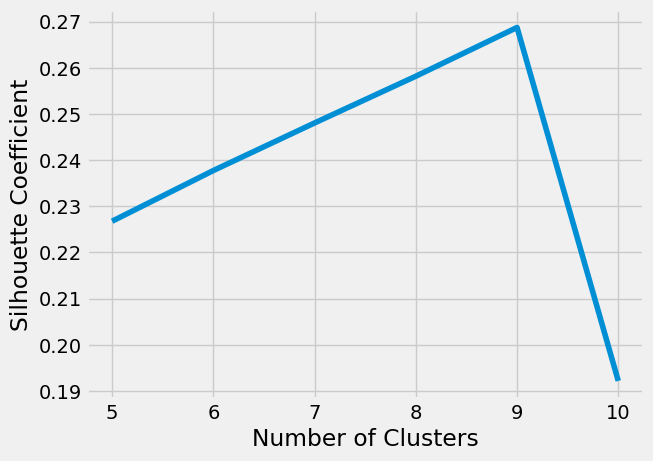

In [12]:
silhouette_coefficients = []

best_score = -1
hypertuned_clusters = 0

for k in range(5, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients.append(score)

    if score > best_score:
        best_score = score
        hypertuned_clusters = k


plt.style.use("fivethirtyeight")
plt.plot(range(5, 11), silhouette_coefficients)
plt.xticks(range(5, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

Use KMeans, DBSCAN, and Agglomerative clustering to compare

/Users/zakirefai/Library/Python/3.8/lib/python/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


Text(0.5, 1.0, 'KMeans')

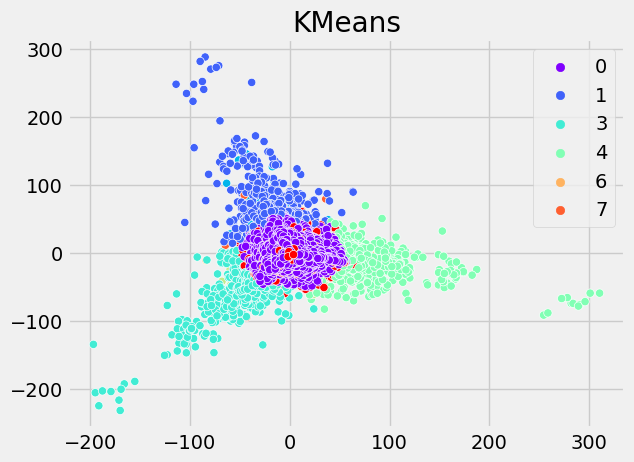

In [13]:
kmeans = KMeans(n_clusters=hypertuned_clusters, **kmeans_kwargs)
kmeans.fit(scaled_features)
centroids = kmeans.cluster_centers_
centroids_pca = pca.transform(centroids)


sns.scatterplot(x=pc1_values, 
                y=pc2_values,
                hue=kmeans.labels_,
                palette="rainbow").set_title('KMeans')

# plt.scatter(pc1_values, pc2_values, c=kmeans.labels_, alpha=0.5, s=200)
# plt.xlabel('PCA 1')
# plt.ylabel('PCA 2')

# plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='X', s=200, linewidths=1,
# color='red', edgecolors="black", lw=1)

# plt.show()

Text(0.5, 1.0, 'AgglomerativeClustering')

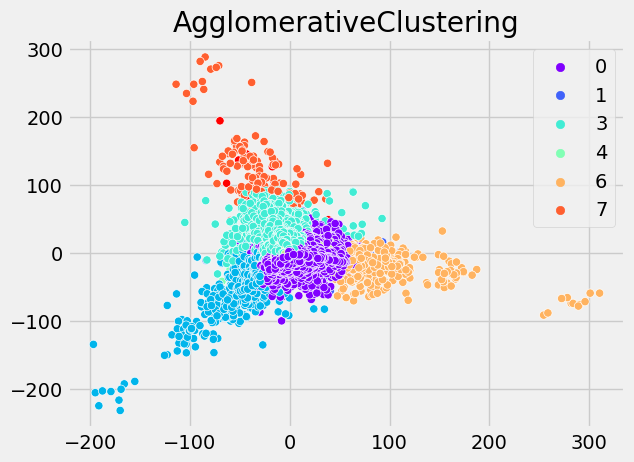

In [14]:
clustering_model_pca = AgglomerativeClustering(n_clusters=hypertuned_clusters, affinity='euclidean', linkage='ward')
clustering_model_pca.fit(pcs)

data_labels_pca = clustering_model_pca.labels_

sns.scatterplot(x=pc1_values,
                y=pc2_values,
                hue=data_labels_pca,
                palette="rainbow").set_title('AgglomerativeClustering')